### Clean & Preprocess Sentiment Analysis Data Prior to Model Training 
A Super Handy CrowdFlower Glossary of Terms can be found [here](https://success.crowdflower.com/hc/en-us/articles/202703305-Glossary-of-Terms)!

In [1]:
import re
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.cluster import MiniBatchKMeans

pd.set_option("display.max_rows", 500)
pd.set_option('display.max_colwidth', -1)

warnings.filterwarnings("ignore", category=DeprecationWarning)

#### Read-In Jobs-Level Data (from CrowdFlower's *Data for Everyone* [library](https://www.crowdflower.com/data-for-everyone/))

In [2]:
in_file = "http://cdn2.hubspot.net/hub/346378/file-2612489700-csv/DFE_CSVs/Airline-Full-Non-Ag-DFE-Sentiment.csv"
variables = ["tweet_id","_golden","text","airline_sentiment","_trust","name"]

cf = pd.read_csv(in_file)[variables]
cf["airline_sentiment"].replace(["positive","neutral","negative"], [1,0,-1], inplace=True)

print cf.columns
print cf.airline_sentiment.value_counts()
cf.head(5)

Index([u'tweet_id', u'_golden', u'text', u'airline_sentiment', u'_trust',
       u'name'],
      dtype='object')
-1    36280
 0    11027
 1    8476 
Name: airline_sentiment, dtype: int64


,tweet_id,_golden,text,airline_sentiment,_trust,name
0,570306133677760513,False,@VirginAmerica What @dhepburn said.,0,0.8108,cairdin
1,570306133677760513,False,@VirginAmerica What @dhepburn said.,0,0.8919,cairdin
2,570306133677760513,False,@VirginAmerica What @dhepburn said.,0,0.7222,cairdin
3,570301130888122368,False,@VirginAmerica plus you've added commercials to the experience... tacky.,1,0.8966,jnardino
4,570301130888122368,False,@VirginAmerica plus you've added commercials to the experience... tacky.,0,0.8108,jnardino


#### Cluster as Positive /Neutral /Negative Tweets Based on Annotated Sentiments
Calculate Tweet Sentiment Score (average jugement weighted by trust score)

In [9]:
def scoreTweets(df):
    df2 = df.copy()
    df2["trustSentiment"] = df2.airline_sentiment*df2._trust
    df2["trustTotal"] = df2._trust
    
    df3 = df2.groupby(by=["tweet_id","_golden","text"], as_index=False)[["trustSentiment","trustTotal"]].sum()
    df3["score"] = df3.trustSentiment / df3.trustTotal
    df3["dupflag"] = df3.duplicated("tweet_id", keep=False) #flag duplicate test-no test tweets
    
    gold = df3[df3._golden==True][["tweet_id","text","score"]]
    nogold = df3[(df3._golden==False) & (df3.dupflag==False)][["tweet_id","text","score"]]
    
    return gold, nogold

In [10]:
cf_g, cf_ng = scoreTweets(cf)
cf_ng.head(5)

,tweet_id,text,score
0,567588278875213824,@JetBlue's new CEO seeks the right balance to please passengers and Wall ... - Greenfield Daily Reporter http://t.co/LM3opxkxch,0
1,567590027375702016,@JetBlue is REALLY getting on my nerves !! 😡😡 #nothappy,-1
2,567591480085463040,@united yes. We waited in line for almost an hour to do so. Some passengers just left not wanting to wait past 1am.,-1
3,567592368451248130,"@united the we got into the gate at IAH on time and have given our seats and closed the flight. If you know people is arriving, have to wait",-1
4,567594449874587648,"@SouthwestAir its cool that my bags take a bit longer, dont give me baggage blue balls-turn the carousel on, tell me it's coming, then not.",-1


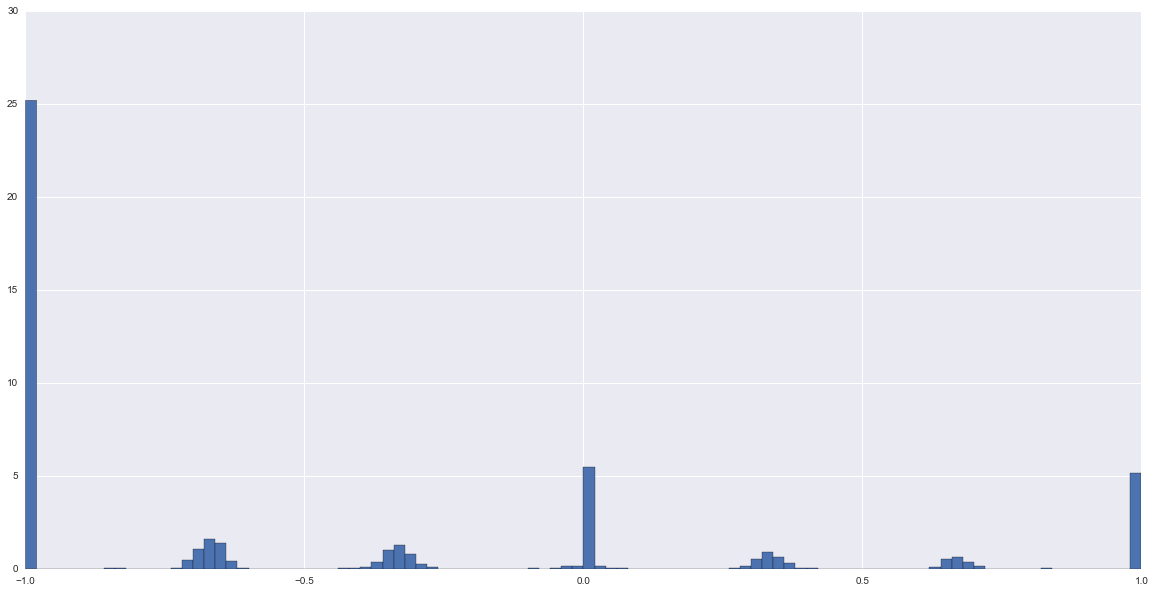

In [12]:
plt.figure(figsize=(20,10))
plt.hist(cf_ng["score"], bins=100, normed=True); #semicolon suppresses array print :)

#### Cluster Tweets into Sentiment Categories by Score

In [ ]:
def clusterTweets(df, n=5):
    kmeans = MiniBatchKMeans(n_clusters=n, random_state=4444)
    data = df.sentScore.reshape(-1, 1)
    clusters = pd.Series(kmeans.fit_predict(data), name="sentCluster")
    
    return pd.concat([df, clusters], axis=1)

In [ ]:
cf_2 = clusterTweets(cf_1)
cf_2.head(5)

In [ ]:
cf_2.groupby(by="sentCluster")["sentScore"].agg([min, max, np.mean])

In [ ]:
cf_2["sentCluster"].replace([0, 1, 2, 3, 4], [1, -1, 0, -0.5, 0.5], inplace=True) 
#note - this might change if we add/ subtract clusters

print cf_2.sentCluster.value_counts()